### Import training and testing data

In [1]:
import pandas as pd
train = pd.read_csv('Data Train.csv')
test = pd.read_csv('Data Test.csv')

In [2]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8913 entries, 0 to 8912
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        8913 non-null   object
 1   komentar  8913 non-null   object
 2   label     8913 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 209.0+ KB


In [3]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2229 entries, 0 to 2228
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        2229 non-null   object
 1   komentar  2229 non-null   object
dtypes: object(2)
memory usage: 35.0+ KB


I wont be able to test the model on the test data.... split the training data?

### Data Inspection

In [4]:
train.head()

,id,komentar,label
0,0utykhgdefh5sc05,"Kamar terlalu kecil, seperti tak terurus, kual...",0
1,cpq5e8rp7x5gwlot,"teryata letaknya sangat jauh dari pusat kota, ...",0
2,23gl9938gdhuv18h,"Toilet bau, ada kecoa, box makanan berantakan ...",0
3,cr7i6e7j95wqyf3t,Lokasinya strategis deket kemana2 tempat makan...,0
4,psomt991rlj9gupn,test,0


row 4 is confusing for training data...

In [5]:
review_text = train.komentar

insp = train
insp["num_words"] = review_text.str.split().str.len()
insp.head()

,id,komentar,label,num_words
0,0utykhgdefh5sc05,"Kamar terlalu kecil, seperti tak terurus, kual...",0,10
1,cpq5e8rp7x5gwlot,"teryata letaknya sangat jauh dari pusat kota, ...",0,21
2,23gl9938gdhuv18h,"Toilet bau, ada kecoa, box makanan berantakan ...",0,24
3,cr7i6e7j95wqyf3t,Lokasinya strategis deket kemana2 tempat makan...,0,51
4,psomt991rlj9gupn,test,0,1


In [6]:
positives = insp[insp.label==1]
positives[positives.num_words < 7].head()

,id,komentar,label,num_words
41,jiphuhcamvdgx6d0,Sayangnya dikamar tidak ada keset,1,5
66,5sh5elulo96eua44,nyaman dan tenang serta pelayanannya baik,1,6
96,4c8vypqbbb98mq8l,"Nyaman,bersih sesuai budget...",1,3
162,v3czrv17w6aayvs2,sangat nyaman dan bersih.hanya agak berisik,1,6
202,qd9k35y9hqcu4xr0,Kamarnya bersih tenang dan nyaman,1,5


I can't base anything on the length of the review text...

### Split Training Data

In [7]:
from sklearn.model_selection import train_test_split

training_text, testing_text = train_test_split(train.komentar, test_size = 0.22, random_state=42)
training_label, testing_label = train_test_split(train.label, test_size = 0.22, random_state=42)

In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer = TfidfVectorizer()
train_text = vectorizer.fit_transform(training_text)
test_text = vectorizer.transform(testing_text)

### Classifiers

#### svm - with GridSearch tuning

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm

parameters = {'kernel':('linear', 'rbf'), 'C':[0.1,1,8,16,32]}
svc = svm.SVC()
svm_clf = GridSearchCV(svc, parameters, cv=5)
svm_clf.fit(train_text, training_label)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 8, 16, 32], 'kernel': ('linear', 'rbf')})

In [10]:
svm_clf.best_params_

{'C': 1, 'kernel': 'linear'}

In [11]:
svm_clf.score(test_text, testing_label)

0.9469658337582866

In [12]:
from sklearn.metrics import f1_score

pred = svm_clf.predict(test_text)
f1_score(testing_label, pred, average=None)

array([0.97028571, 0.7535545 ])

Does great classifying the negatives, not so much with the positives

let's check the sentiment count

In [13]:
train.label.value_counts()

0    7686
1    1227
Name: label, dtype: int64

That is a huge imbalance... if I even them out, the positive scores might go down... I'd be working with a lot less data

#### svm confusion matrix on training data

0    1713
1     248
Name: label, dtype: int64


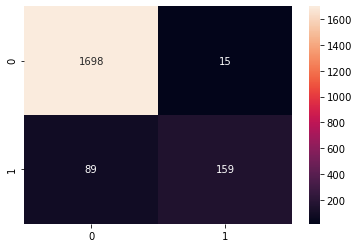

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

cm = confusion_matrix(testing_label, pred, labels=[0,1])
df_cm = pd.DataFrame(cm, index=[0,1], columns=[0,1])

sns.heatmap(df_cm, annot=True, fmt='d')
print((testing_label.value_counts()))

Predicted values are the y-axis

In [15]:
89/248 * 100

35.88709677419355

over 35% of positives were predicted to be negatives... no bueno

#### Even em out, see what happens

In [16]:
negative = train[train.label == 0]
positive = train[train.label == 1]
evened_neg = negative[:len(positive)]

comb = evened_neg, positive
evened_dat = pd.concat(comb)

evened_dat.label.value_counts()

0    1227
1    1227
Name: label, dtype: int64

In [17]:
training_text1, testing_text1 = train_test_split(evened_dat.komentar, test_size = 0.22, random_state=42)
training_label1, testing_label1 = train_test_split(evened_dat.label, test_size = 0.22, random_state=42)

In [18]:
train_text1 = vectorizer.fit_transform(training_text1)
test_text1 = vectorizer.transform(testing_text1)

In [19]:
svm_clf1 = GridSearchCV(svc, parameters, cv=5)
svm_clf1.fit(train_text1, training_label1)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 8, 16, 32], 'kernel': ('linear', 'rbf')})

In [20]:
svm_clf1.best_params_

{'C': 1, 'kernel': 'rbf'}

In [21]:
svm_clf1.score(test_text1, testing_label1)

0.8648148148148148

In [22]:
pred1 = svm_clf1.predict(test_text1)
f1_score(testing_label1, pred1, average=None)

array([0.87215412, 0.85658153])

Score for positive predictions are much better

1    274
0    266
Name: label, dtype: int64


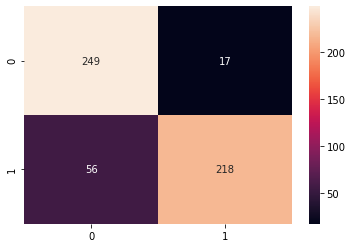

In [23]:
cm1 = confusion_matrix(testing_label1, pred1, labels=[0,1])
df_cm1 = pd.DataFrame(cm1, index=[0,1], columns=[0,1])

sns.heatmap(df_cm1, annot=True, fmt='d')
print((testing_label1.value_counts()))

In [24]:
print(17 / 266 * 100)
print(56 / 274 * 100)

6.390977443609022
20.437956204379564


15% improvement... hmmm

Conclusion: Better to use evened out data.

#### naive bayes 
this is supposed to be good for binary classification...

In [25]:
from sklearn.naive_bayes import BernoulliNB
import numpy as np

nb_clf = BernoulliNB()
nb_clf.fit(train_text1, training_label1)

BernoulliNB()

In [26]:
nb_clf.score(test_text1, testing_label1)

0.825925925925926

In [27]:
pred_nb = nb_clf.predict(test_text1)
f1_score(testing_label1, pred_nb, average=None)

array([0.82061069, 0.83093525])

1    274
0    266
Name: label, dtype: int64


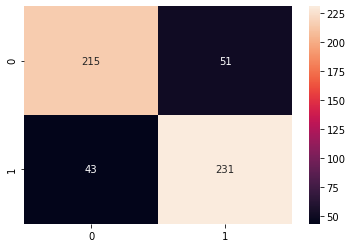

In [28]:
cm_nb = confusion_matrix(testing_label1, pred_nb, labels=[0,1])
df_cm_nb = pd.DataFrame(cm_nb, index=[0,1], columns=[0,1])

sns.heatmap(df_cm_nb, annot=True, fmt='d')
print((testing_label1.value_counts()))

In [29]:
print(51/266*100)
print(43/274*100)

19.172932330827066
15.693430656934307


this does better at predicting positives, worse at predicting negatives

#### Logistic Regression

In [30]:
from sklearn.linear_model import LogisticRegression
import numpy as np

logreg_parameters = {'penalty':["l1","l2"], 'C':np.logspace(-3,3,7)}
log = LogisticRegression(max_iter=1000, solver="liblinear")
clf_log = GridSearchCV(log, logreg_parameters, cv=10)
clf_log.fit(train_text1, training_label1)

GridSearchCV(cv=10,
             estimator=LogisticRegression(max_iter=1000, solver='liblinear'),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']})

In [31]:
clf_log.best_params_

{'C': 10.0, 'penalty': 'l2'}

In [32]:
clf_log.score(test_text1, testing_label1)

0.8592592592592593

In [33]:
pred_log = clf_log.predict(test_text1)
f1_score(testing_label1, pred_log, average=None)

array([0.86330935, 0.85496183])

1    274
0    266
Name: label, dtype: int64


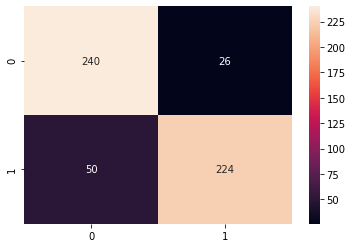

In [34]:
cm_log = confusion_matrix(testing_label1, pred_log, labels=[0,1])
df_cm_log = pd.DataFrame(cm_log, index=[0,1], columns=[0,1])

sns.heatmap(df_cm_log, annot=True, fmt='d')
print((testing_label1.value_counts()))

In [35]:
print(26/266*100)
print(50/274*100)

9.774436090225564
18.248175182481752


#### Cost-Sensitive SVM and LogReg 

In [36]:
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedStratifiedKFold

In [62]:
# grid search class weights with svm for imbalance classification

# define model
model = svm.SVC(gamma='scale')
# define grid
balance = [{0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}]
param_grid = dict(class_weight=balance) 

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv,
                    scoring='roc_auc')
# execute the grid search
# grid_result_svc = grid.fit(trainf, train.label)
grid_result_svc = grid.fit(train_text, training_label)
# report the best configuration
print("Best: %f using %s" % (grid_result_svc.best_score_, grid_result_svc.best_params_))


Best: 0.950961 using {'class_weight': {0: 1, 1: 10}}


In [42]:
# grid search class weights with logistic regression for imbalance classification

# define model
model = LogisticRegression(solver='lbfgs')
# define grid search
grid_log = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, 
                        scoring='roc_auc')
# execute the grid search
grid_result_log = grid_log.fit(train_text, training_label)
# report the best configuration
print("Best: %f using %s" % (grid_result_log.best_score_, grid_result_log.best_params_))


Best: 0.948780 using {'class_weight': {0: 1, 1: 10}}


In [64]:
print(grid_result_svc.score(test_text, testing_label))
print(grid_result_log.score(test_text, testing_label))

0.9482703425418526
0.9436684368114796


In [66]:
pred_svc_ = grid_result_svc.predict(test_text)
print(f1_score(testing_label, pred_svc_, average=None))

pred_log_ = grid_result_log.predict(test_text)
print(f1_score(testing_label, pred_log_, average=None))

[0.9716576  0.76923077]
[0.94446112 0.68697124]


svm does better.

0    1713
1     248
Name: label, dtype: int64


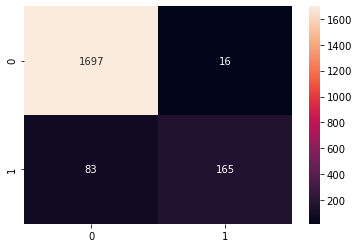

In [67]:
cm_svm_ = confusion_matrix(testing_label, pred_svc_, labels=[0,1])
df_cm_svm_ = pd.DataFrame(cm_svm_, index=[0,1], columns=[0,1])

sns.heatmap(df_cm_svm_, annot=True, fmt='d')
print((testing_label.value_counts()))

This only does slightly better than the raw svm

### Conclusion:
We'll use this ^^

In [38]:
trainf = vectorizer.fit_transform(train.komentar)
testf = vectorizer.transform(test.komentar)

In [56]:
test["label"] = grid.predict(testf)

In [57]:
test.label.value_counts()

0    1993
1     236
Name: label, dtype: int64

In [58]:
out = test.drop(columns='komentar')
out.head()

,id,label
0,40tvlbae7zq6a9h9,0
1,olebpcybyecwypsz,0
2,tfm2rpkpsmd517ot,0
3,53hcsxg6o92o0wcs,0
4,jgl6va9ycj0ogu9q,0


In [59]:
out.to_csv("cssvm.csv", index=False)